In [1]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from unityagents import UnityEnvironment

environment = UnityEnvironment(file_name="Banana/Banana.exe", no_graphics=True)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [15]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, n_neurons=128):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, n_neurons)
        self.layer2 = nn.Linear(n_neurons, n_neurons)
        #self.layer2_2 = nn.Linear(n_neurons, n_neurons)
        self.layer3 = nn.Linear(n_neurons, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        #x = F.relu(self.layer2_2(x))
        return self.layer3(x)

In [28]:
class Agent():
    def __init__(self, environment, batch_size=128, gamma=0.99, eps_start=0.9, eps_end=0.1, eps_decay=1000, tau=0.005, lr=1e-4, memory_size=10000, n_neurons=128, update_every=1):
        self.env = environment
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.tau = tau
        self.lr = lr
        self.n_neurons = n_neurons
        self.episode_rewards = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        self.update_every = update_every

        info = self.env.reset(train_mode=True)[self.brain_name]
        state = info.vector_observations[0]
        n_actions = self.brain.vector_action_space_size
        n_observations = len(state)

        self.policy_net = DQN(n_observations, n_actions, self.n_neurons).to(self.device)
        self.target_net = DQN(n_observations, n_actions, self.n_neurons).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.lr, amsgrad=True)
        self.memory = ReplayMemory(memory_size)

        self.steps_done = 0


    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
            math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([random.sample(range(0,4), 1)], device=self.device, dtype=torch.long)


    def plot_durations(self, show_result=False):
        plt.figure(1)
        rewards_t = torch.tensor(self.episode_rewards, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.plot(rewards_t.numpy())
        if len(rewards_t) >= 100:
            means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.axhline(y=13, color='r')
        plt.pause(0.001)
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        current_batch = batch.action
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def load(self, filename):
        config = torch.load(filename, map_location=torch.device("cpu").type)
        self.policy_net.load_state_dict(config["policy_net_state_dict"])
        self.policy_net.to(self.device)
        self.optimizer.load_state_dict(config["optimizer_state_dict"])
        self.batch_size = config["batch_size"]
        self.gamma = config["gamma"]
        self.eps_start = config["eps_start"]
        self.eps_end = config["eps_end"]
        self.eps_decay = config["eps_decay"]
        self.tau = config["tau"]
        self.episode_rewards = config["episode_rewards"]
        self.memory = config["memory"]
        self.lr = config["lr"]
        self.steps_done = config["steps_done"]
        self.n_neurons = config["n_neurons"]
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.to(self.device)

    def save(self, filename):
        torch.save({
                'policy_net_state_dict': self.policy_net.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'batch_size': self.batch_size,
                'gamma': self.gamma,
                'eps_start': self.eps_start,
                'eps_end': self.eps_end,
                'eps_decay': self.eps_decay,
                'tau': self.tau,
                'episode_rewards': self.episode_rewards,
                'memory': self.memory,
                'steps_done': self.steps_done,
                'lr': self.lr,
                'n_neurons': self.n_neurons
            }, filename)
        
    def train(self, iterations=1000):
        for _ in range(iterations):
            episode_reward = 0
            info = self.env.reset(train_mode=True)[self.brain_name]
            state = info.vector_observations[0]
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            while True:
                action = self.select_action(state)
                info = self.env.step(int(action))[self.brain_name]
                next_state = info.vector_observations[0]
                reward = info.rewards[0]
                done = info.local_done[0]
                reward = torch.tensor([reward], device=self.device)
                episode_reward += reward
                next_state = torch.tensor(next_state, dtype=torch.float32, device=self.device).unsqueeze(0)

                self.memory.push(state, action, next_state, reward)

                state = next_state

                if self.steps_done % self.update_every != 0 and not done:
                    continue 

                self.optimize_model()

                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
                self.target_net.load_state_dict(target_net_state_dict)

                if done:
                    self.episode_rewards.append(episode_reward)
                    self.plot_durations()
                    break


In [29]:
agent = Agent(environment, n_neurons=128, memory_size=10000, tau=1e-3, lr=5e-4, update_every=4)

Complete


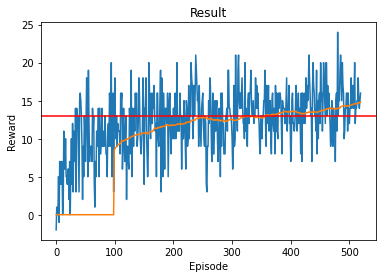

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [30]:
filename = "model1.pth"
agent.load(filename)
try:
    agent.train(10)
finally:
    agent.save(filename)
    print('Complete')
    agent.plot_durations(show_result=True)
    plt.ioff()
    plt.show()

In [31]:
environment.close()